# Simulation possibilities

This notebook looks into some simulation ideas for the FDAA case. It tests certain assumptions and distributions to support the design of the simulation engine.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')

In [2]:
incidents = pd.read_csv("Data/incidenten_2017.csv", sep=";", decimal=",")
deployments = pd.read_csv("Data/inzetten_2017.csv", sep=";", decimal=",")

C:\Users\s100385\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 1. Interarrival times

If there is a distribution to be found in the interarrival times of incidents in a demand location / postal code, we can use this to simulate the timing of incidents efficiently.

In [3]:
# 10 most busy postal codes
postcodes = ['1012', '1013', '1017', '1102', '1018', '1069', '1016', '1068', '1097', '1055']

In [4]:
incidents["dim_incident_postcode_digits"] = incidents["dim_incident_postcode"].str[0:4]
incidents["dim_incident_start_datumtijd"] = pd.to_datetime(incidents["dim_incident_start_datumtijd"])
incidents.sort_values("dim_incident_start_datumtijd", ascending=True, inplace=True)


In [5]:
top10 = incidents[np.isin(incidents["dim_incident_postcode_digits"], postcodes)]
intertimes = top10.groupby("dim_incident_postcode_digits").apply(lambda x: 
                                                                 x.sort_values("dim_incident_start_datumtijd", ascending=True)\
                                                                 ["dim_incident_start_datumtijd"].diff(1)[1:].dt.seconds/3600)\
                                                          .reset_index(level=1, drop=True)\
                                                          .reset_index()

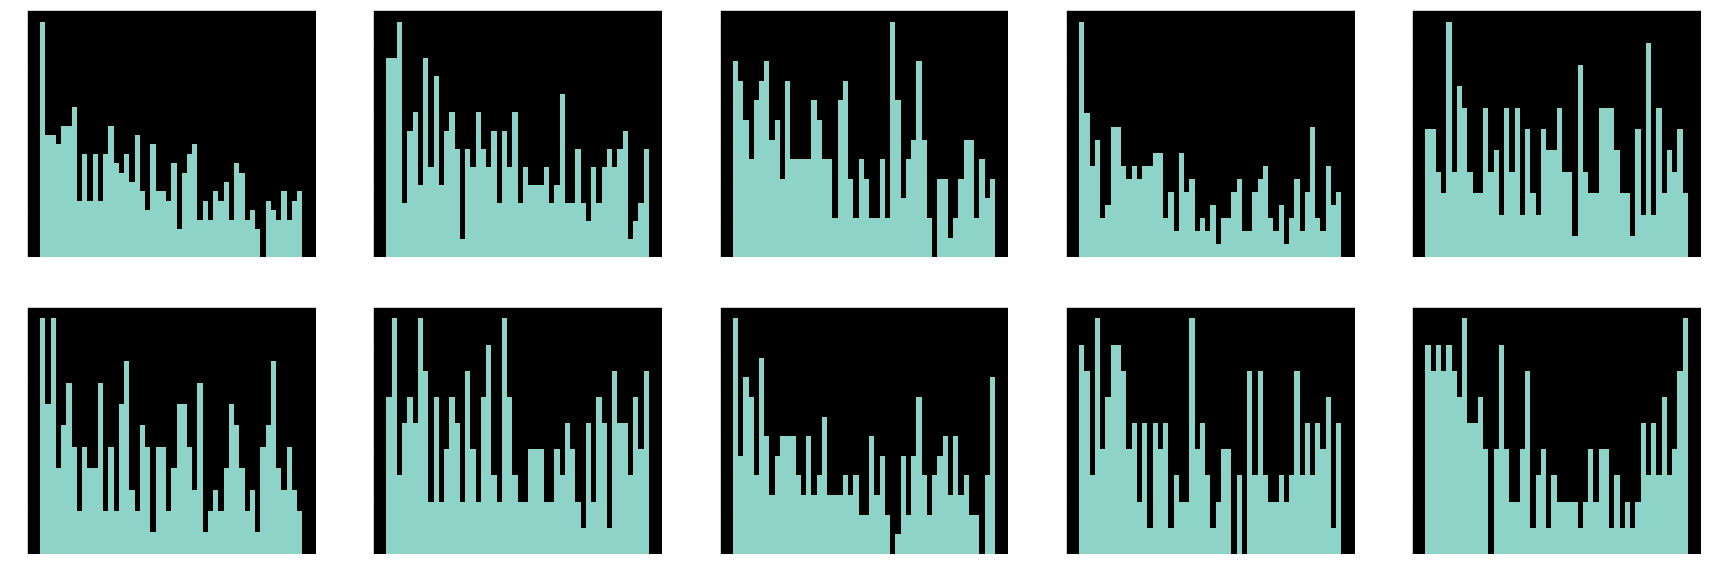

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(30,10))

for i in range(len(postcodes)):
    
    temp = intertimes[intertimes["dim_incident_postcode_digits"]==postcodes[i]]
    
    if i >= 5:
        axes[1,i-5].hist(temp["dim_incident_start_datumtijd"], bins=50)
    else: 
        axes[0,i].hist(temp["dim_incident_start_datumtijd"], bins=50)
    
plt.show()

There does not seem to be a clear distribution in these interarrival times. One might say they are completely random. Maybe a Poisson distribution is suitable?

In [7]:
incidents["interarrival_time"] = incidents["dim_incident_start_datumtijd"].diff().dt.seconds / 60

In [8]:
incidents["interarrival_time"].max() / (60*24)

0.4378009259259259

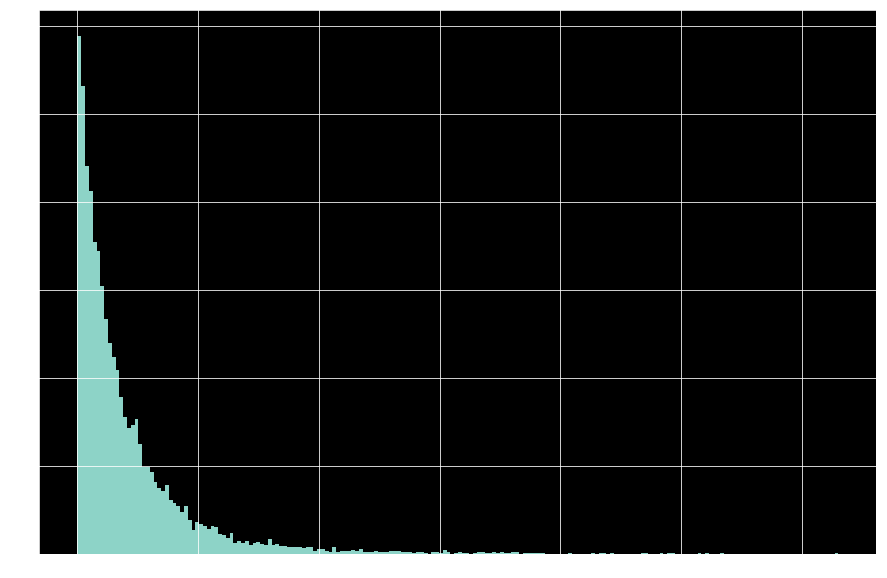

In [9]:
incidents["interarrival_time"].astype(float).hist(bins=200, figsize=(15,10))

In [10]:
print("In 2017, there were {} incidents that occurred within 1 minute of the previous incident.".format(sum(incidents["interarrival_time"] < 1)))
print("{} incidents occurred within one hour of the previous incident (total incidents: {}).".format(sum(incidents["interarrival_time"] < 60), len(incidents)))

In 2017, there were 391 incidents that occurred within 1 minute of the previous incident.
10032 incidents occurred within one hour of the previous incident (total incidents: 12754).


Look only at peak time: between 10 AM and 8 PM.

In [11]:
incidents["dim_tijd_dagdeel"].unique()

array(['Nacht', 'Ochtend', 'Middag', 'Avond'], dtype=object)

In [12]:
peak_incidents = incidents[(incidents["dim_tijd_uur"]>=10)&(incidents["dim_tijd_uur"]<20)]

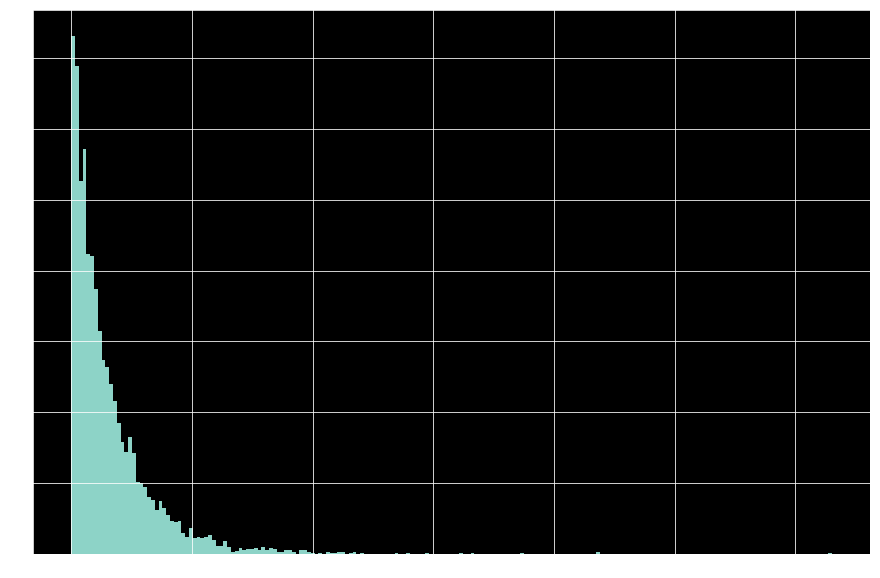

In [13]:
peak_incidents["interarrival_time"].astype(float).hist(bins=200, figsize=(15,10))

In [14]:
L = peak_incidents["interarrival_time"].mean()
print("Average interarrival time: {}".format(L))

Average interarrival time: 31.519243598778445


Try exponential interarrival rate:

C:\Users\s100385\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\s100385\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


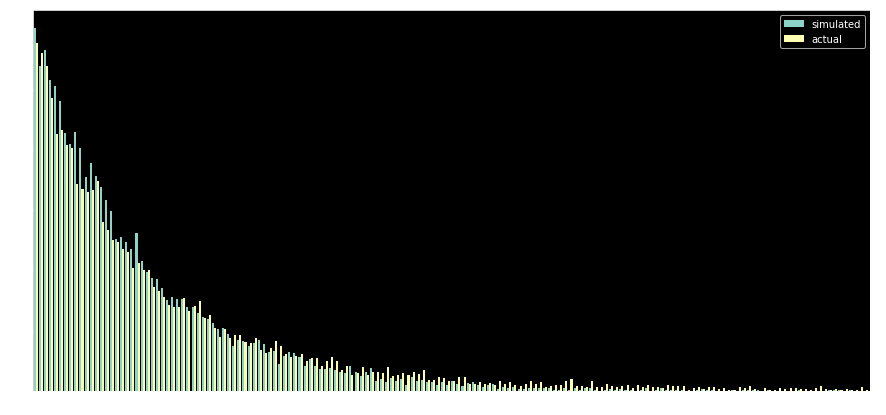

In [32]:
x = np.random.exponential(L, len(incidents))
y = incidents["interarrival_time"].astype(float)
labels=["simulated", "actual"]

def plot_double_hist(x, y, labels, bins=200, xlim=250):
    fig, ax = plt.subplots(figsize=(15,7))
    #plt.hist(x, bins=200, alpha=0.7)
    #plt.hist(y, bins=200, alpha=0.7)
    ax.hist([x,y], label=labels, bins=bins)
    ax.set_xlim((0,xlim))
    plt.legend()
    plt.show()
    
plot_double_hist(x, y, labels)

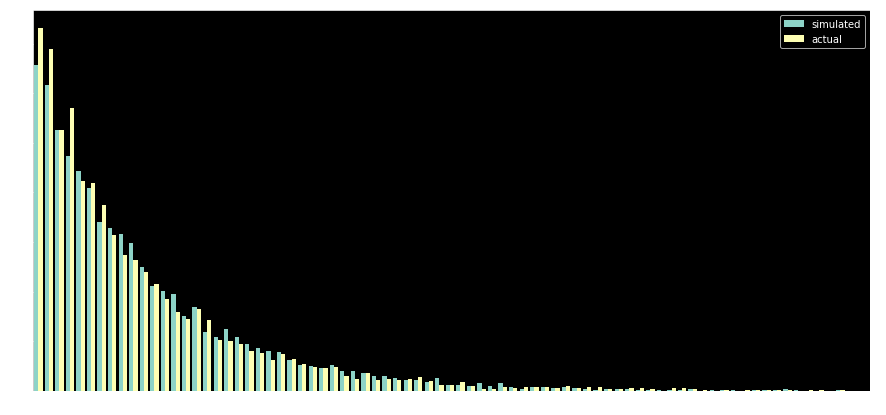

In [28]:
y2 = peak_incidents["interarrival_time"].astype(float)
x = np.random.exponential(L, len(peak_incidents))
plot_double_hist(x, y2, labels)

<strong>The interarrival times seem to exactly follow the exponential distribution, at least if we look at all events in the whole safety region.</strong>

<p>We could sample from this distribution and then sample the demand location as a multinomial. Alternatively, we could see if this distribution also holds for separate "demand locations" (e.g. postcodes), so that we can simulate the arrivals separately for different locations, according to the respective rates in each location. Downside of the latter is that it is hard to say something about the distribution for areas with low activity. The first options thus seems best.</p>



In [46]:
def compare_sim_and_actual(postcode):
    y = peak_incidents[peak_incidents["dim_incident_postcode_digits"]==postcode]["interarrival_time"].astype(float)
    L = y.mean()
    x = np.random.exponential(L, len(y))
    plot_double_hist(x, y, ["simulated", "actual"], bins=round(len(x)/2), xlim=50)
    

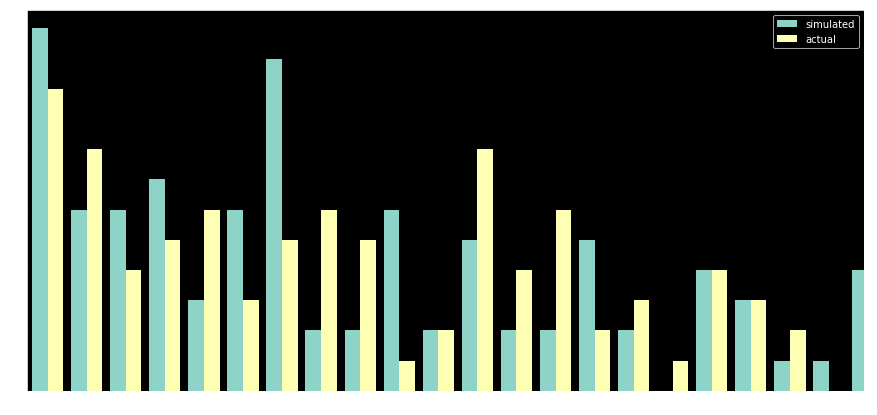

In [52]:
compare_sim_and_actual(postcodes[9])

Simulating separate interarrival times for different locations also seems possible for the busiest postal codes, but maybe not for less busy areas..

In any case, we still need to distinguish between different types, priorities, and the required number of vehicles (of different types). This could be done using multinomial distributions.

## 2. Probabilities of demand locations, incident types, priorities, and number of vehicles

### 2.1 probability that an incident occurs in a specific demand location

We are looking for the probability that an incident occurs in location x, given that an incident occurs somewhere in the region.

In [126]:
def add_postcode_digits(incident_data, remove_missing=True):
    if remove_missing:
        incident_data = incident_data[~incident_data["dim_incident_postcode"].isnull()].copy()
    incident_data["dim_incident_postcode_digits"] = incident_data["dim_incident_postcode"].str[0:4]
    return incident_data

In [127]:
incidents = add_postcode_digits(incidents)

In [130]:
def get_prob_per_demand_location(incident_data, location="postcode_digits"):
    """ Calculate the proportion of incidents that happens in every demand location. 
    
    :param incident_data: Pandas DataFrame with incident data.
    :param location: How to define the demand locations. Must be one of ["postcode_digits", "grid"].
    :return: Tuple of two numpy arrays with the probabilities and demand location names respectively.
    """
    
    if location=="postcode_digits":
        incident_data.sort_values("dim_incident_postcode_digits", ascending=True, inplace=True)
        incident_data = incident_data.groupby("dim_incident_postcode_digits")["dim_incident_id"].count() / len(incident_data)
        return np.array(incident_data), np.array(incident_data.index)
    else:
        print("Only 'postcode_digits' is currently implemented.")

In [131]:
location_probs, demand_location_names = get_prob_per_demand_location(incidents)
print(sum(location_probs))

0.9999999999999993


In [132]:
print(demand_location_names[:10])

['1011' '1012' '1013' '1014' '1015' '1016' '1017' '1018' '1019' '1021']


In [108]:
# incidents[incidents["dim_incident_postcode"].isnull()]
sum(incidents["dim_incident_postcode"].isnull())

0

A number of incidents (764) has no postal code. These are mostly outside fires (buitenbrand) and general aid (algemene hulpverlening). There are however street names, so the postal code should be obtainable. Given the uncertainty regarding the definition of demand locations, we do not go into this now. Specifically, we might use a grid layout instead of the postal codes, in which case this is not a problem anymore.

### 2.2 distribution of incident types for each demand location
We should determine this distribution separately for each demand location, because different demographic and geographic characteristics will lead to different distributions.

In [133]:
def get_type_probs_per_location(incident_data, location="postcode_digits"):
    if location=="postcode_digits":
        incident_data.sort_values("dim_incident_postcode_digits", ascending=True, inplace=True)
        incident_data = incident_data.groupby(["dim_incident_postcode_digits", "dim_incident_incident_type"])["dim_incident_id"].count().reset_index()
        incident_data["type_prob_per_location"] = incident_data.groupby("dim_incident_postcode_digits")["dim_incident_id"].apply(lambda x: x/x.sum())
        probs_per_location = pd.pivot_table(incident_data, index="dim_incident_incident_type", columns="dim_incident_postcode_digits", 
                                            values="type_prob_per_location").fillna(0)
        types = np.array(probs_per_location.index)
        return {loc : list(probs_per_location[loc]) for loc in probs_per_location.columns}, types

In [134]:
prob_dict, type_names = get_type_probs_per_location(incidents)
type_names

array(['Assistentie Ambulance', 'Assistentie Politie', 'Binnenbrand',
       'Brandgerucht / nacontrole', 'Buitenbrand', 'Dier te water',
       'Herbezetting', 'Hulpverlening Dieren', 'Hulpverlening algemeen',
       'Hulpverlening water algemeen', 'Liftopsluiting',
       'Meten / overlast / verontreiniging', 'NVT',
       'OMS / automatische melding', 'Persoon te water', 'Reanimeren',
       'Storm en Waterschade', 'Voertuig te water'], dtype=object)

In [138]:
prob_dict["1011"]

[0.09433962264150944,
 0.03773584905660377,
 0.05660377358490566,
 0.06289308176100629,
 0.050314465408805034,
 0.0,
 0.0,
 0.006289308176100629,
 0.1509433962264151,
 0.006289308176100629,
 0.07547169811320754,
 0.06289308176100629,
 0.0,
 0.2578616352201258,
 0.050314465408805034,
 0.05660377358490566,
 0.025157232704402517,
 0.006289308176100629]

### 2.3 probabilities of priority levels given the incident type

In [139]:
def get_prio_probabilities_per_type(incident_data):
    """ Create dictionary with the probabilities of having priority 1, 2, and 3 for 
        every incident type. 
        
    :param incident_data: Pandas DataFrame containing the log of incidents from which
                          the probabilities should be obtained.
    :return: Dictionary with incident type names as keys and lists of length 3 as elements.
             The lists have probabilities of prio 1, 2, 3 in position 0, 1, 2 respectively.
    """
    
    prio_per_type = incident_data.groupby(["dim_incident_incident_type", "dim_prioriteit_prio"])["dim_incident_id"].count().reset_index()
    prio_per_type["prio_probability"] = prio_per_type.groupby(["dim_incident_incident_type"])["dim_incident_id"].apply(lambda x: x/x.sum())
    prio_probabilities = pd.pivot_table(prio_per_type, columns="dim_incident_incident_type", values="prio_probability", index="dim_prioriteit_prio").fillna(0)
    return {col : list(prio_probabilities[col]) for col in prio_probabilities.columns}

In [142]:
prio_dict = get_prio_probabilities_per_type(incidents)
prio_dict["Assistentie Ambulance"]

[0.6321626617375231, 0.3659889094269871, 0.0018484288354898336]

In [143]:
incidents.columns

Index(['dim_incident_id', 'dim_incident_straatnaam_nen',
       'dim_incident_postcode', 'dim_incident_plaatsnaam',
       'dim_incident_incident_type', 'dim_datum_datum', 'dim_datum_jaar',
       'dim_datum_maand_nr', 'dim_datum_maand_dag_nr', 'dim_datum_week_nr',
       'dim_datum_kwartaal', 'dim_datum_maand_naam_nl',
       'dim_datum_dag_naam_nl', 'dim_datum_jaar_maand_code',
       'dim_prioriteit_prio', 'dim_tijd_uur', 'dim_tijd_dagdeel',
       'inc_dim_object_type', 'inc_dim_object_functie', 'inc_dim_object_naam',
       'dim_classificatie_object_type', 'dim_classificatie_brand_type',
       'dim_incident_afstand', 'dim_incident_start_datumtijd',
       'dim_incident_eind_datumtijd', 'key', 'dim_incident_brandoorzaak_hoofd',
       'dim_incident_brandoorzaak_sub',
       'dim_incident_brandoorzaak_brandschademodel', 'hub_object_id',
       'sat_incident_classificatie_ind_risicoprofiel',
       'sat_incident_details_start_tijd', 'sat_incident_details_start_datum',
       'sat_in

In [149]:
incidents[["dim_classificatie_object_type", "dim_incident_brandoorzaak_brandschademodel", 
           "dim_classificatie_brand_type", "meldingsclassificatie_1", "meldingsclassificatie_2", "meldingsclassificatie_3", "profiel_object"]].head()

,dim_classificatie_object_type,dim_incident_brandoorzaak_brandschademodel,dim_classificatie_brand_type,meldingsclassificatie_1,meldingsclassificatie_2,meldingsclassificatie_3,profiel_object
12397,bag,NaN,NVT,Alarm,Autom. brand,Autom. brand OMS,NaN
11822,bag,NaN,NVT,Leefmilieu,Stank/Hinder. lucht,NVT,NaN
7781,bag,NaN,NVT,Dienstverlening,Brandweer,Liftopsluiting,NaN
1325,bag,NaN,NVT,Gezondheid,Scenario,B-rit Zorgambu,NaN
1845,bag,NaN,Binnen,Brand,Specifiek,Brandgerucht,NaN


### 2.4 Vehicles